In [62]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore


In [63]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00


In [64]:
import mplfinance as mpf

# 1. Data Loading and Exploration

In [2]:
from google.colab import files
uploaded = files.upload()

Saving DataApple.zip to DataApple.zip


In [3]:
!unzip DataApple.zip

Archive:  DataApple.zip
  inflating: AAPL, 1D 01012007-12072023.csv  


In [16]:
df = pd.read_csv('AAPL, 1D 01012007-12072023.csv')


In [28]:
df.head()

,volume,vwap,open,close,high,low,transactions,readable_date,month,year_month
0,1.245445e+09,3.0302,3.0821,2.9929,3.0921,2.9250,189737,2007-01-03,1,2007-01
1,8.554834e+08,3.0403,3.0018,3.0593,3.0696,2.9936,136333,2007-01-04,1,2007-01
2,8.352580e+08,3.0426,3.0632,3.0375,3.0786,3.0143,141050,2007-01-05,1,2007-01
3,7.974138e+08,3.0683,3.0700,3.0525,3.0904,3.0457,130547,2007-01-08,1,2007-01
4,3.352007e+09,3.1946,3.0875,3.3061,3.3207,3.0411,569578,2007-01-09,1,2007-01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4159 entries, 0 to 4158
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   volume        4159 non-null   float64
 1   vwap          4159 non-null   float64
 2   open          4159 non-null   float64
 3   close         4159 non-null   float64
 4   high          4159 non-null   float64
 5   low           4159 non-null   float64
 6   time          4159 non-null   int64  
 7   transactions  4159 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 260.1 KB


In [7]:
df.isnull().sum()

,0
volume,0
vwap,0
open,0
close,0
high,0
low,0
time,0
transactions,0


In [8]:
df.duplicated().sum()

0

In [18]:
df_copy = df.copy()

In [20]:

# Conversion Utc to readble date
df['readable_date'] = pd.to_datetime(df['time'], unit='s')
df['readable_date'] = df['readable_date'].dt.strftime('%Y-%m-%d')

In [23]:
df.drop(columns=['time'], inplace=True)

In [21]:
df.describe()

,volume,vwap,open,close,high,low,time,transactions
count,4.159000e+03,4159.000000,4159.000000,4159.000000,4159.000000,4159.000000,4.159000e+03,4.159000e+03
mean,3.662925e+08,46.391382,46.362788,46.396058,46.881127,45.865790,1.428315e+09,2.709318e+05
std,3.724793e+08,50.277557,50.235593,50.293482,50.843874,49.680104,1.505279e+08,2.510859e+05
min,2.422234e+07,2.841000,2.835400,2.792900,2.928600,2.792900,1.167800e+09,3.048700e+04
25%,1.067497e+08,11.936200,11.955700,11.947150,12.028400,11.853600,1.297876e+09,1.128150e+05
50%,2.136463e+08,25.885200,25.775000,25.825000,26.262800,25.680000,1.428466e+09,1.782460e+05
75%,4.965321e+08,52.154150,52.263750,52.231250,52.626250,51.796250,1.558627e+09,3.259555e+05
max,3.373042e+09,193.102000,193.780000,193.970000,194.480000,191.760000,1.689134e+09,2.966979e+06


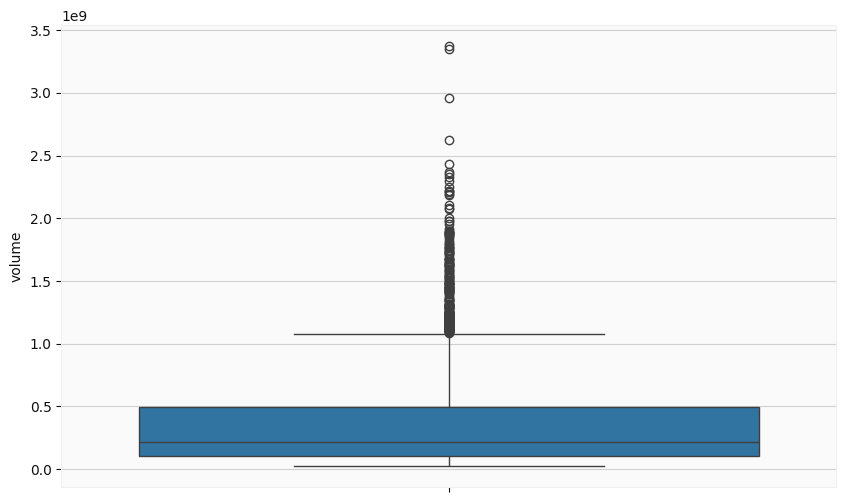

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['volume'])
plt.show()

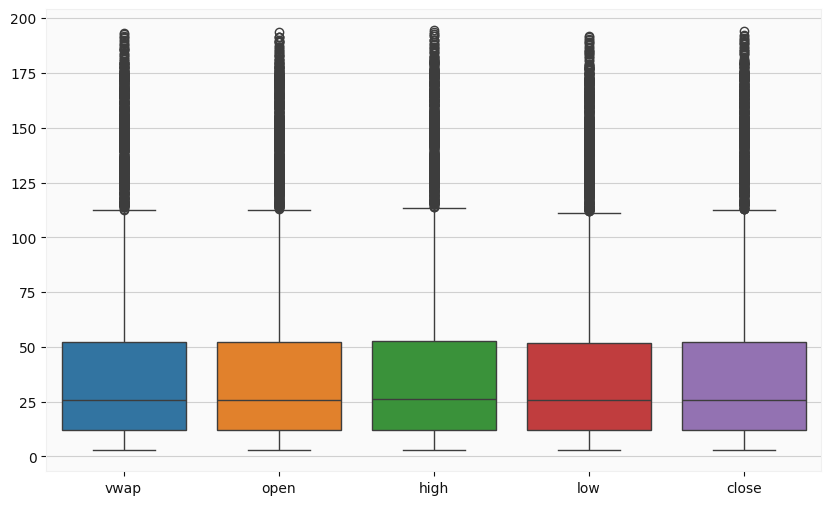

In [88]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['vwap', 'open', 'high', 'low', 'close']])
plt.show()
plt.show()

It seems to me that in this analysis outliers (even the most extreme ones are not accidental) and I do not plan to process them somehow

# Time trends

<Axes: title={'center': 'Monthly Average Volume'}, xlabel='month'>

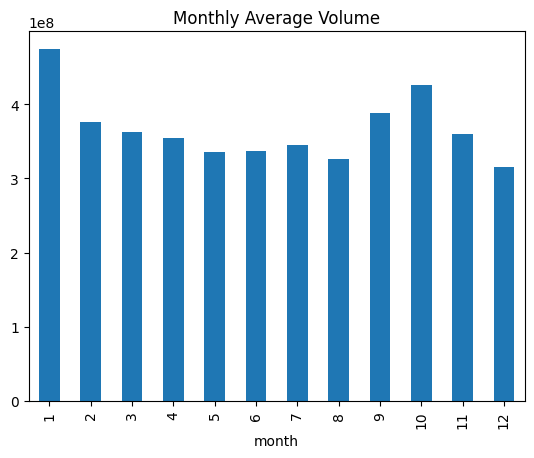

In [25]:
df['readable_date'] = pd.to_datetime(df['readable_date'])
df['month'] = df['readable_date'].dt.month
monthly_avg = df.groupby('month')['volume'].mean()
monthly_avg.plot(kind='bar', title='Monthly Average Volume')

The maximum average trading volume. This may be due to the January effect, a phenomenon where investors actively buy stocks at the beginning of the year

Volumes are below average. This may be due to seasonal holidays (summer holidays in August and Christmas in December), when there is less activity in the market.

It is believed that major collapses always happen in October and at this time it is better to get out of the market.


**Statistical Analysis volume seasonality**

In [91]:
##ANOVA analysis
#H0 : Average stock volume do not depend on the month.
#H1 : average stock volume depend on the month.

monthly_groups = [group['volume'] for _, group in df.groupby('month')]
f_statistic, p_value = stats.f_oneway(*monthly_groups)



print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in average stock volume between months.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in average stock volume between months.")


F-statistic: 5.12529578086245
p-value: 4.9558912368797774e-08
Reject the null hypothesis. There is a significant difference in average stock volume between months.


here we confirm the assumption that the sales volume depends on the month

**Evaluation of the vwap change over time**

In [27]:
df['year_month'] = df['readable_date'].dt.to_period('M')

In [45]:
vwap_trend = df.groupby('year_month')['vwap'].mean()
vwap_trend = pd.DataFrame(vwap_trend)       #some confersions because of errrors
vwap_trend.reset_index(inplace=True)


vwap_trend['year_month'] = vwap_trend['year_month'].astype(str)

vwap_trend.head()

,year_month,vwap
0,2007-01,3.175505
1,2007-02,3.064337
2,2007-03,3.235705
3,2007-04,3.350255
4,2007-05,3.876100


In [48]:
# vwap trend plot creating

fig = px.line(vwap_trend, x='year_month', y='vwap', title='VWAP Trend')

fig.update_layout(
    xaxis_title='Year-Month',
    yaxis_title='VWAP'
)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
        ]
        )
    )
)


fig.show()

The graph shows that the vwap has been growing very smoothly and slowly for a long time,

the biggest jump in price is observed in the summer of 2020 (covid?)

After that, there is a period of turbulence (then down, then up) with another sharp jump from January 2023

In any case, since 2007, we can observe a fairly smooth positive trend in stock prices. There have been ups and downs over the past few years, but the stock market usually perfectly reflects what is happening in the world, and Covid in 2020 launched a chain reaction of problems in the technology sector, as many firms are heavily dependent on manufacturing in Asia (where the lockdown has long persisted). Well, that's my guess.

# Estimation of minimum and maximum prices by month

In [50]:
df.head()

,volume,vwap,open,close,high,low,transactions,readable_date,month,year_month
0,1.245445e+09,3.0302,3.0821,2.9929,3.0921,2.9250,189737,2007-01-03,1,2007-01
1,8.554834e+08,3.0403,3.0018,3.0593,3.0696,2.9936,136333,2007-01-04,1,2007-01
2,8.352580e+08,3.0426,3.0632,3.0375,3.0786,3.0143,141050,2007-01-05,1,2007-01
3,7.974138e+08,3.0683,3.0700,3.0525,3.0904,3.0457,130547,2007-01-08,1,2007-01
4,3.352007e+09,3.1946,3.0875,3.3061,3.3207,3.0411,569578,2007-01-09,1,2007-01


In [55]:
monthly_prices = df.groupby('month').agg({
    'high': 'mean',
    'low': 'mean'
}).reset_index()


monthly_prices.head()


,month,high,low
0,1,45.235565,44.132251
1,2,46.475820,45.461008
2,3,47.316718,46.171242
3,4,47.195285,46.259378
4,5,47.975450,46.969325


In [57]:
#the month with the highest and lowest average maximum price

max_price_month = monthly_prices.loc[monthly_prices['high'].idxmax()]
min_price_month = monthly_prices.loc[monthly_prices['low'].idxmin()]

print("Month with the highest average price:", max_price_month['month'])
print("Month with the lowest average price:", min_price_month['month'])

Month with the highest average price: 6.0
Month with the lowest average price: 1.0


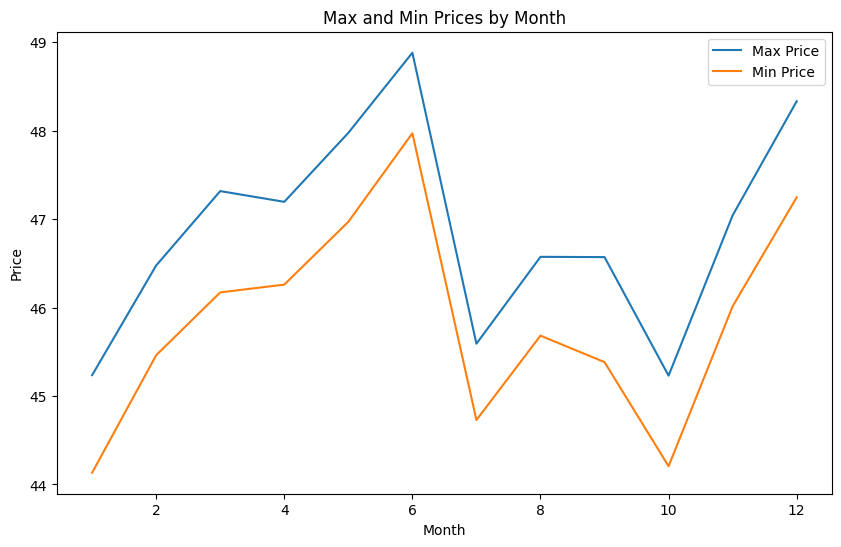

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_prices['month'], monthly_prices['high'], label='Max Price')
plt.plot(monthly_prices['month'], monthly_prices['low'], label='Min Price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Max and Min Prices by Month')
plt.legend()
plt.show()

**Statistical Analysis price seasonality**

In [90]:
#ANOVA analysis
#H0 : Average stock prices do not depend on the month.
#H1 : average stock prices depend on the month.

monthly_groups = [group['close'] for _, group in df.groupby('month')]
f_statistic, p_value = stats.f_oneway(*monthly_groups)



print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in average stock prices between months.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in average stock prices between months.")

F-statistic: 0.18793011638430623
p-value: 0.9982385575640709
Fail to reject the null hypothesis. There is no significant difference in average stock prices between months.


we cannot say that the season affects the price.

# Visualization of stock price data for a certain period from 2020

In [68]:
df_2020 = df[(df['readable_date'] >= '2020-01-01')]
df_2020.set_index('readable_date', inplace=True)

In [77]:
df_2020.head()

,volume,vwap,open,close,high,low,transactions,month,year_month
readable_date,,,,,,,,,
2020-01-02,135647456.0,74.6099,74.0600,75.0875,75.150,73.7975,283480,1,2020-01
2020-01-03,146535512.0,74.7026,74.2875,74.3575,75.145,74.1250,280940,1,2020-01
2020-01-06,118518576.0,74.4499,73.4475,74.9500,74.990,73.1875,242860,1,2020-01
2020-01-07,111510620.0,74.7311,74.9600,74.5975,75.225,74.3700,227868,1,2020-01
2020-01-08,132363784.0,75.2914,74.2900,75.7975,76.110,74.2890,261770,1,2020-01


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




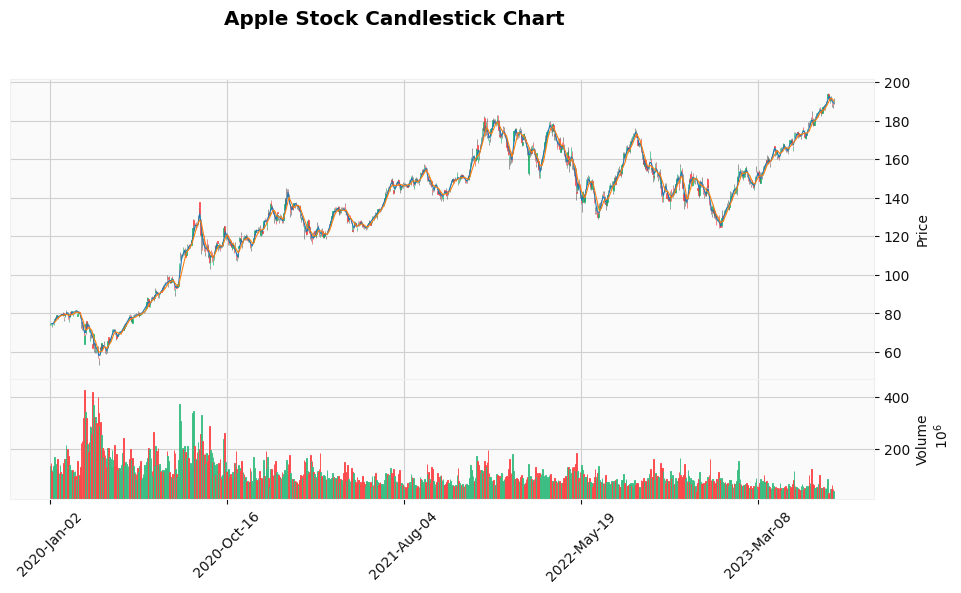

In [70]:
mpf.plot(
    df_2020,
    type = 'candle',
    volume = True,
    title='Apple Stock Candlestick Chart',
    style='yahoo',
    ylabel='Price',
    ylabel_lower='Volume',
    figsize=(12, 6),
    mav=(3, 6),
)
mpf.show()

too much data for this type of graph, not very visually

In [73]:
import plotly.graph_objects as go

In [ ]:
df_2020.reset_index(inplace=True)

In [84]:
# lets create in plotly
fig = go.Figure(data=[go.Candlestick(
    x=df_2020['readable_date'],
    open=df_2020['open'],
    high=df_2020['high'],
    low=df_2020['low'],
    close=df_2020['close'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])

fig.update_layout(
    title='Apple Stock Price',
    xaxis_title='Date',
    yaxis_title='Price',
)

fig.show()

The graph is an example of building using candlesticks. It's hard for me to draw any conclusions from this because I don't understand anything about stocks at all

**Trend linear regression**

In [93]:
df_2020['time_numeric'] = (df['readable_date'] - df['readable_date'].min()).dt.days

<ipython-input-93-8897585ebcbf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
X = df_2020[['time_numeric']]
y = df_2020['close']
model = LinearRegression()
model.fit(X, y)

print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)

if model.coef_[0] > 0:
    print("The trend is positive.")
else:
    print("The trend is negative.")

Slope: 0.06980566491586174
Intercept: 90.24858504241914
The trend is positive.


Here I checked using linear regression that the trend has been positive since 2020, although of course it is noticeable on the chart